# GPR with optimization from sklearn

Inspired by [Gaussian Processes for Time Series Forecasting](https://juanitorduz.github.io/gaussian_process_time_series/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error

# Set plotting style
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## The dataset

### Load and present data

In [4]:
df = pd.read_csv('../data/CSCO_data.csv')
df = df[6000:8000]
co2_mean = df['Close'].mean()
co2_std = df['Close'].std()
display(df.columns)
display(df)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

,Date,Open,High,Low,Close,Adj Close,Volume
6000,2016-10-27,30.600000,30.670000,30.360001,30.379999,24.075138,16926200
6001,2016-10-28,30.360001,30.799999,30.350000,30.590000,24.241550,19946800
6002,2016-10-31,30.340000,30.770000,30.320000,30.680000,24.312872,23225400
6003,2016-11-01,30.850000,30.860001,30.230000,30.480000,24.154383,17542100
6004,2016-11-02,30.430000,30.680000,30.230000,30.389999,24.083061,19174000
...,...,...,...,...,...,...,...
7800,2023-12-22,49.840000,50.389999,49.840000,50.090000,49.300465,12900700
7801,2023-12-26,50.110001,50.400002,50.049999,50.279999,49.487465,9721200
7802,2023-12-27,50.299999,50.560001,50.279999,50.439999,49.644943,10414300
7803,2023-12-28,50.580002,50.630001,50.419998,50.480000,49.684315,8549900


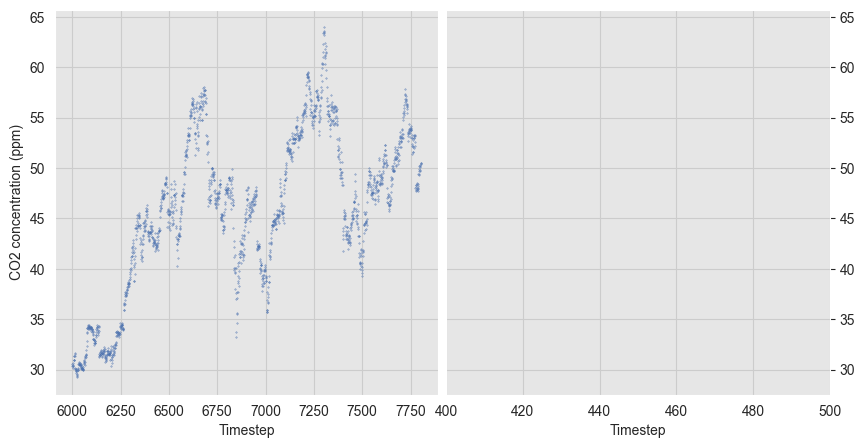

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(df.index, df["Close"], s=0.1)
ax[0].set_ylabel("CO2 concentration (ppm)")
ax[1].scatter(df.index, df["Close"], s=0.1)
ax[1].set_xlim((400, 500))
ax[1].yaxis.tick_right()
ax[0].set_xlabel("Timestep")
ax[1].set_xlabel("Timestep")

plt.subplots_adjust(wspace=0.02)
plt.show()

### Create training and testing sets

In [7]:
split_ratio = 0.8
n = len(df)
n_train = int(n * split_ratio)

# Convert data to numpy arrays
x = df.index.values.reshape(-1, 1)
y = df['Close'].values.reshape(n, 1)

# Split data into training and test sets
x_train = x[:n_train]
x_test = x[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

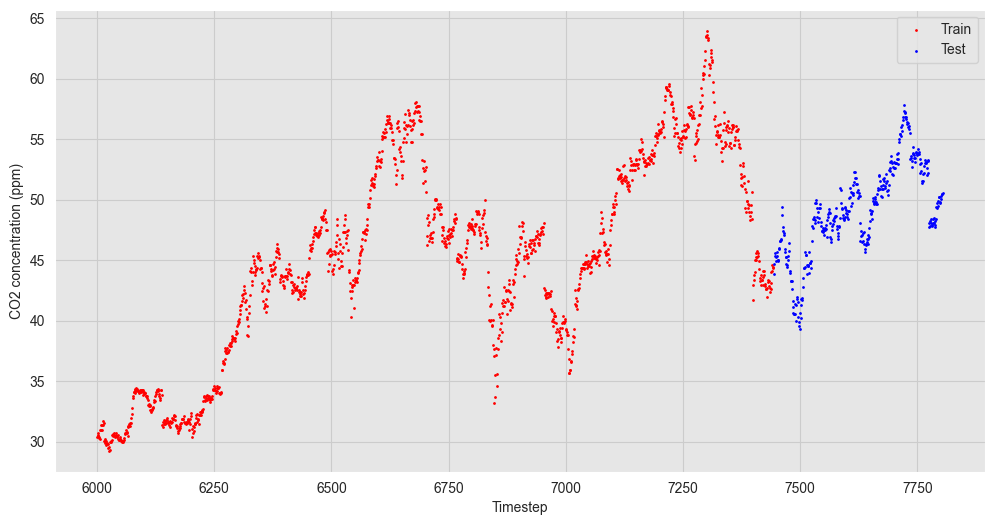

In [8]:
plt.scatter(x_train, y_train, c='r', s=1., label='Train')
plt.scatter(x_test, y_test, c='b', s=1., label='Test')
plt.xlabel('Timestep')
plt.ylabel('CO2 concentration (ppm)')
plt.legend()
plt.show()

## Model fitting

### Define the GP kernel function

In [9]:
# Term responsible for the noise in data
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

# Term responsible for the nonlinear trend in data
k1 = ConstantKernel(constant_value=10, constant_value_bounds=(1, 500)) * \
  RBF(length_scale=500, length_scale_bounds=(1, 1e4))

# Term responsible for the seasonal component in data
k2 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=10, periodicity_bounds=(8, 15))

kernel_4  = k0 + k1 + k2

### Draw samples from the GP prior

In [10]:
# Define GaussianProcessRegressor object. 
gpr = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0,
)

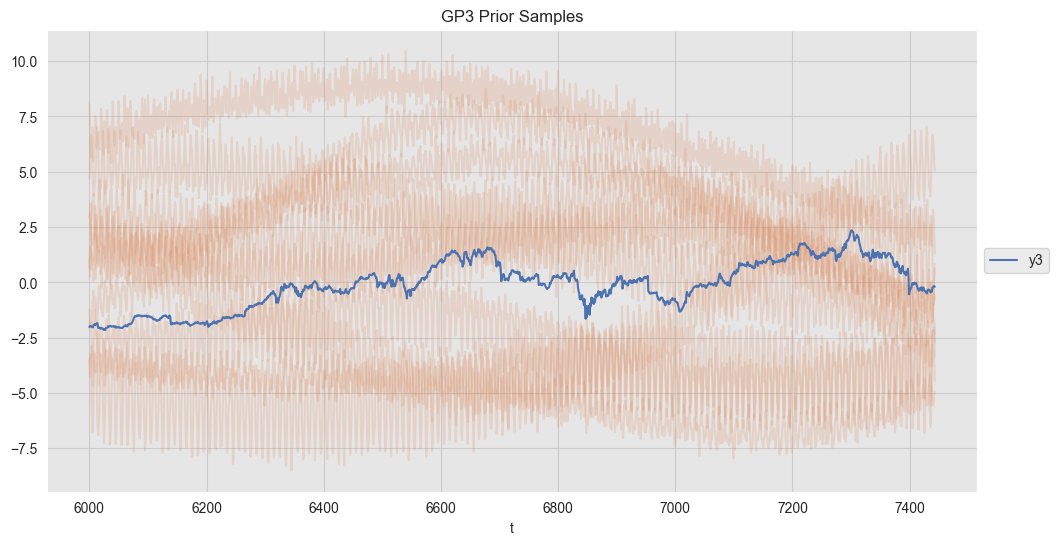

In [11]:
n_samples = 10
gp3_prior_samples = gpr.sample_y(X=x_train, n_samples=n_samples)

fig, ax = plt.subplots()
for i in range(n_samples):
    sns.lineplot(x=x_train[...,0], y = gp3_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=x_train[...,0], y=(y_train[..., 0] - co2_mean) / co2_std, color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP3 Prior Samples', xlabel='t');

### Fit the GP model

In [12]:
gpr.fit(x_train, y_train)

/Users/wciezobka/venvs/agh-py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wciezobka/venvs/agh-py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 3.16**2 * RBF(length_scale=500) + 1**2 * ExpSineSquared(length_scale=1, periodicity=10),
                         n_restarts_optimizer=10, normalize_y=True)

In [13]:
gpr.kernel_

WhiteKernel(noise_level=0.01) + 1**2 * RBF(length_scale=10.8) + 0.0322**2 * ExpSineSquared(length_scale=1.94, periodicity=13.5)

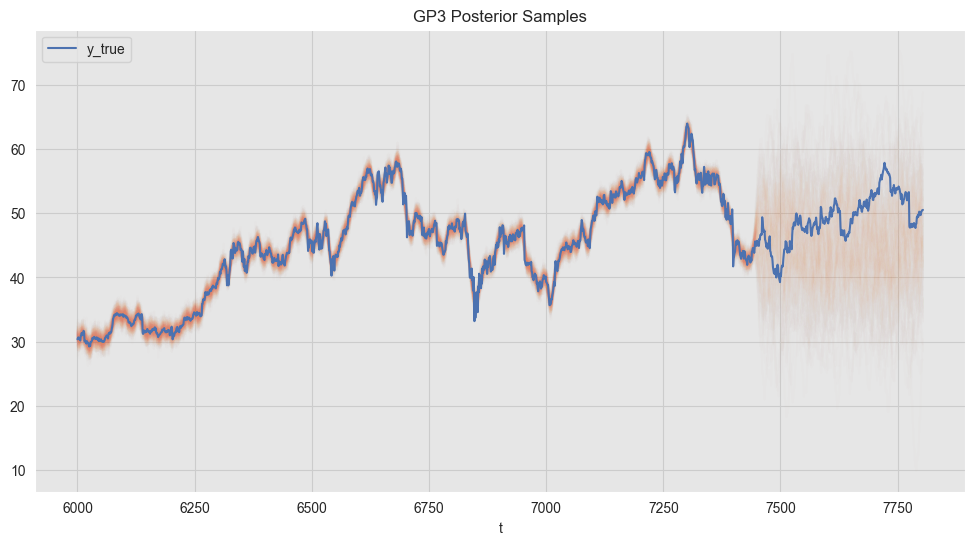

In [14]:
gp3_posterior_samples = gpr.sample_y(X=x, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=x[...,0], y = gp3_posterior_samples[:, i], color=sns_c[1], alpha=0.01, ax=ax)
sns.lineplot(x=x[...,0], y=y[..., 0], color=sns_c[0], label='y_true', ax=ax, alpha=1.) 
ax.legend()
ax.set(title='GP3 Posterior Samples', xlabel='t');

### Forecast on the test set

In [15]:
y_pred, y_std = gpr.predict(x, return_std=True)

df['y_pred'] = y_pred
df['y_std'] = y_std
df['y_pred_lwr'] = df['y_pred'] - 2*df['y_std']
df['y_pred_upr'] = df['y_pred'] + 2*df['y_std']

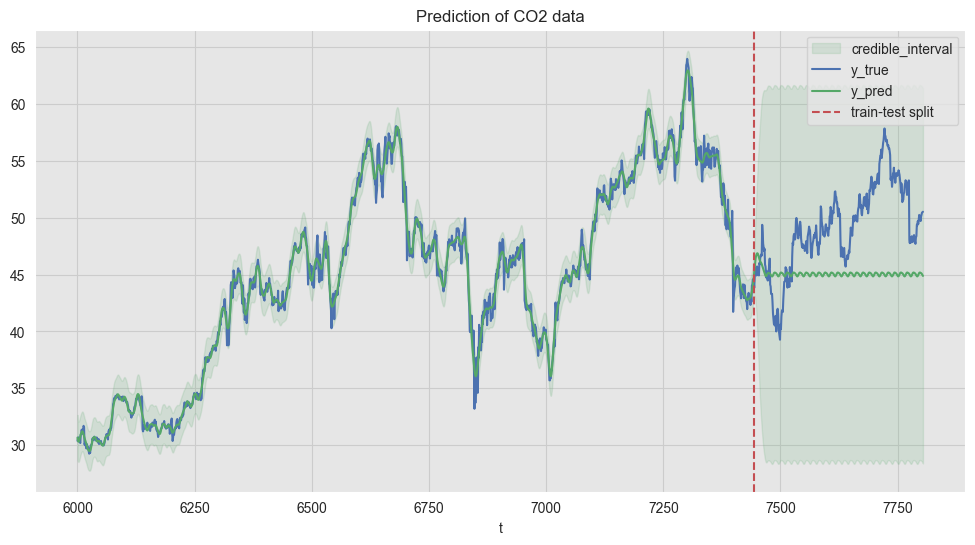

In [19]:
df['t'] = df.index

fig, ax = plt.subplots()

ax.fill_between(
    x=df['t'], 
    y1=df['y_pred_lwr'], 
    y2=df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='Close', data=df, color=sns_c[0], label = 'y_true', ax=ax)
sns.lineplot(x='t', y='y_pred', data=df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(6000 + n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend()
ax.set(title='Prediction of CO2 data', xlabel='t', ylabel='');

## Model evaluation

In [20]:
print(f'R2 Score Train = {gpr.score(X=x_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gpr.score(X=x_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gpr.predict(x_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gpr.predict(x_test)): 0.3f}')

R2 Score Train =  0.994
R2 Score Test = -1.134
MAE Train =  0.461
MAE Test =  4.674


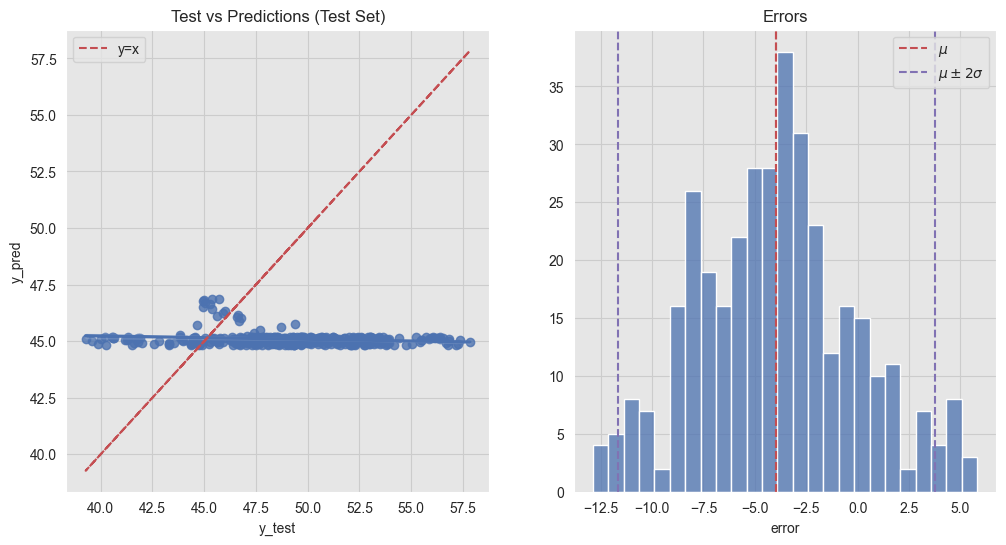

In [21]:
errors = gpr.predict(x_test) - np.squeeze(y_test)
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gpr.predict(x_test).flatten(), ax=ax[0])
ax[0].plot(y_test.flatten(), y_test.flatten(), color=sns_c[3], linestyle='--', label='y=x')
sns.histplot(data=errors, ax=ax[1], bins=25)
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[0].legend()
ax[1].legend()
ax[0].set(title='Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Errors', xlabel='error', ylabel=None);